In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Loading data

In [108]:
X_data = pd.read_csv('data/train_data.csv')
X_data_test = pd.read_csv('data/1234.csv', sep=';')
X_data_ktest = pd.read_csv('data/test_data.csv')
y_data = pd.read_csv('data/train_target.csv', header=-1, names=['agreed'])

In [109]:
y_data_test = X_data_test['y']
X_data_test.drop(['y'], axis = 1, inplace = True, errors = 'ignore')

In [110]:
y_data_test = pd.DataFrame(y_data_test)
y_data_test['y'] = y_data_test.apply(lambda row: 1 if row['y'] == 'yes' else 0, axis=1)

In [111]:
print('Is everything ok?: ',  X_data.shape[0] == y_data.shape[0])
print('And duplicates?: ',  np.all(X_data.duplicated() == False))

Is everything ok?:  True
And duplicates?:  False


Checking if balanced sample:


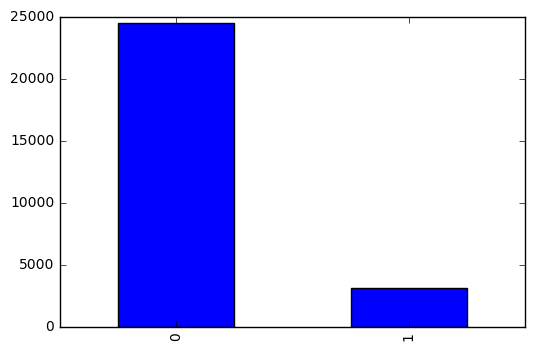

In [112]:
print('Checking if balanced sample:')
y_data['agreed'].value_counts().plot(kind='bar')

# Working with features

In [113]:
X_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.000000,27595.00000
mean,40.085994,258.874542,2.568328,962.693169,0.172024,0.087211,93.577443,-40.503026,3.628844,5167.31696
std,10.480548,260.511236,2.765561,186.371948,0.492548,1.567343,0.578193,4.616641,1.730084,72.22960
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.60000
25%,32.000000,101.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.10000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.00000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.10000
max,94.000000,4199.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.10000


In [114]:
def convert_features(data):
    conv_data = data.copy()
    
    wage_earners = ['admin.', 'blue-collar', 'technician', 'services', 'management']
    
    conv_data['wage_earner'] = conv_data.apply(lambda row: 1 if row['job'] in wage_earners else 0, axis=1)
    
    conv_data['marital'] = conv_data.apply(lambda row: 'single' if row['marital'] ==  'unknown' else row['marital'], axis=1)
    
    conv_data['default'] = conv_data.apply(lambda row: 1 if row['default'] == 'yes' else 0, axis=1)
    
    conv_data['housing'] = conv_data.apply(lambda row: 1 if row['housing'] == 'yes' else 0, axis=1)
    
    conv_data['loan'] = conv_data.apply(lambda row: 1 if row['loan'] == 'yes' else 0, axis=1)
    
    conv_data['contacted_before'] = conv_data.apply(lambda row: 1 if row['pdays'] != 999 else 0, axis=1)
    
    conv_data['contacted_before_campaign'] = conv_data.apply(lambda row: 1 if row['previous'] >= 1 else 0, axis=1)
    
    conv_data['contacted_before_campaign'] = conv_data.apply(lambda row: 1 if row['previous'] >= 1 else 0, axis=1)

    # nominal values
    nom_df = conv_data[['marital', 'education', 'poutcome', 'day_of_week', 'month', 'contact']]
    conv_data = conv_data.drop(nom_df.columns, axis=1)
    nom_df = pd.get_dummies(nom_df)
    conv_data = pd.concat([conv_data, nom_df], axis = 1)
    
    # drop unused
    conv_data = conv_data.drop(['job', 'default', 'pdays', 'previous'], axis = 1)
    
    return conv_data

In [115]:
X_data = convert_features(X_data)

In [116]:
X_data_test = convert_features(X_data_test)

In [117]:
X_data_ktest = convert_features(X_data_ktest)

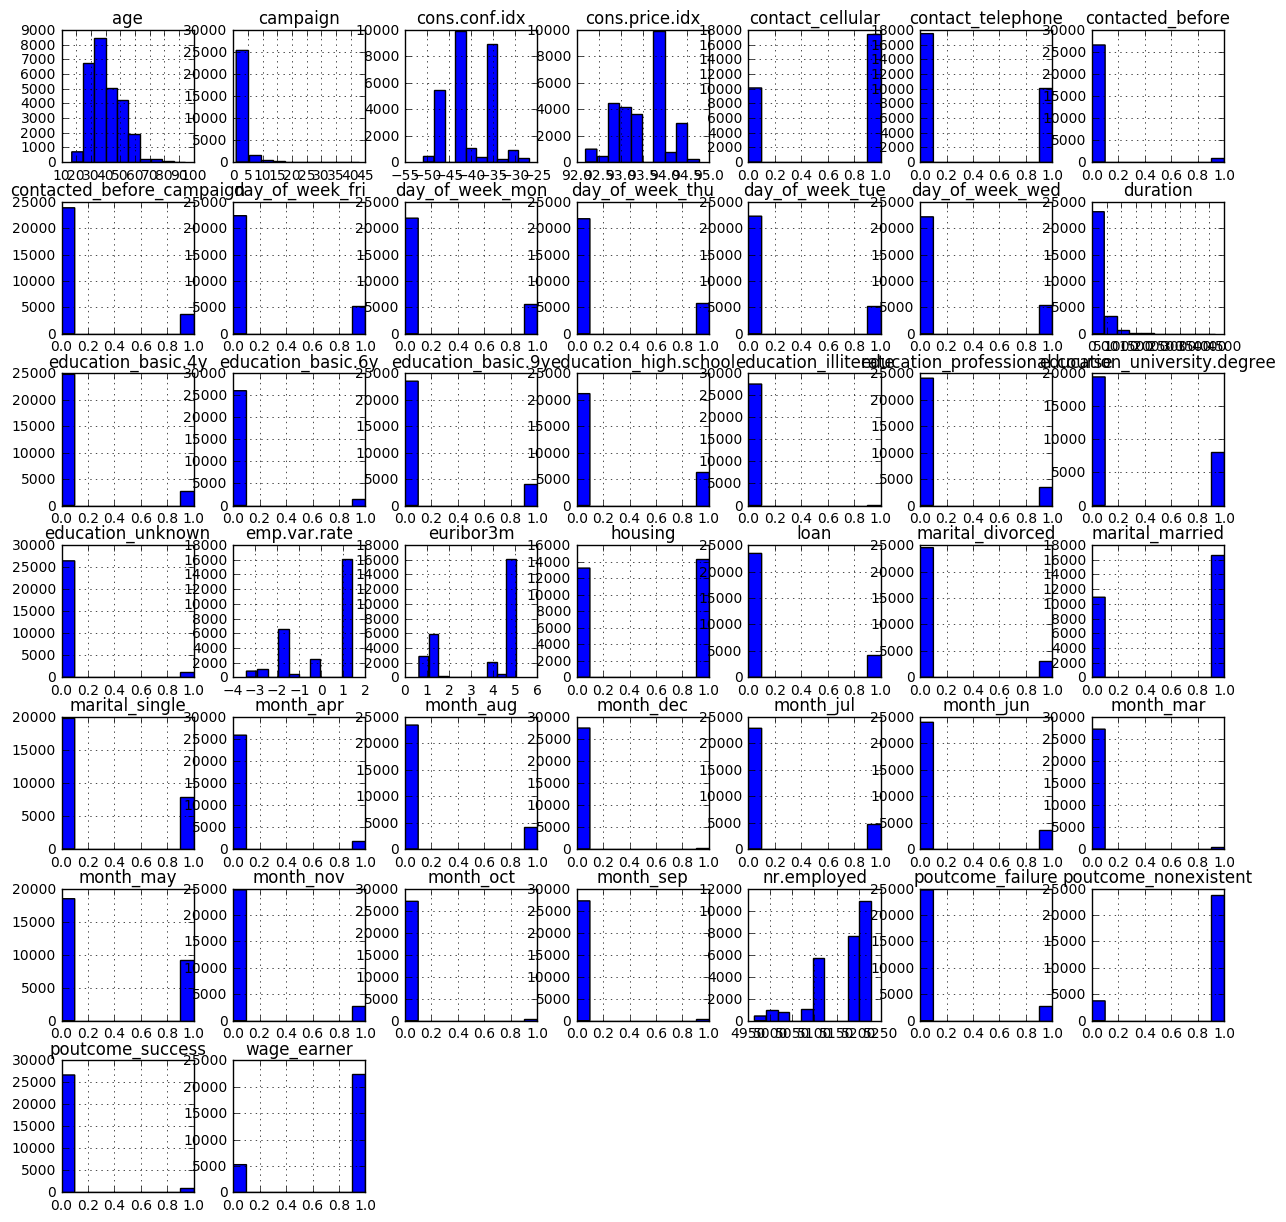

In [118]:
X_data.hist(figsize=(15, 15));

In [119]:
X_data.corrwith(y_data['agreed'])

age                              0.032164
housing                          0.013259
loan                            -0.005903
duration                         0.408124
campaign                        -0.071472
emp.var.rate                    -0.299526
cons.price.idx                  -0.136918
cons.conf.idx                    0.051229
euribor3m                       -0.308978
nr.employed                     -0.353859
wage_earner                     -0.074771
contacted_before                 0.326550
contacted_before_campaign        0.197625
marital_divorced                -0.009789
marital_married                 -0.043256
marital_single                   0.053741
education_basic.4y              -0.009280
education_basic.6y              -0.025658
education_basic.9y              -0.048707
education_high.school           -0.004045
education_illiterate             0.010091
education_professional.course    0.002344
education_university.degree      0.047182
education_unknown                0

# Scaling data

In [122]:
from sklearn.preprocessing import MinMaxScaler

In [123]:
# minmax = MinMaxScaler(feature_range=(0, 1))
# X_data = minmax.fit_transform(X_data)


# Splitting data into train/test sets

In [124]:
from sklearn.model_selection import train_test_split

In [125]:
RANDOM_SEED = 3491
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data['agreed'].values, test_size=0.33, random_state = RANDOM_SEED)

# Fitting models

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [127]:
def top_importance_print(n, importances, importances_names):
    indexes = importances.argsort()[-n:][::-1]
    for i, index in enumerate(indexes):
        print ('#{} Important feature is -- {} with {:.2f} importance'.format(i + 1, importances_names[index], importances[index]))

## Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
kf = StratifiedKFold(n_splits = 30, random_state=RANDOM_SEED)
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 5, 10, 15, 20, 25, 30, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced']}
cv = GridSearchCV(RandomForestClassifier(), param, scoring='roc_auc', n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

Best score:  0.942253990502
Params:  {'max_features': 25, 'max_depth': 8, 'class_weight': 'balanced', 'criterion': 'entropy'}


In [130]:
y_t = cv.predict(X_test)

In [131]:
roc_auc_score(y_test, y_t)

0.8795374575691266

In [132]:
top_importance_print(10, cv.best_estimator_.feature_importances_, X_data.columns)

#1 Important feature is -- duration with 0.51 importance
#2 Important feature is -- nr.employed with 0.19 importance
#3 Important feature is -- emp.var.rate with 0.06 importance
#4 Important feature is -- cons.conf.idx with 0.06 importance
#5 Important feature is -- euribor3m with 0.05 importance
#6 Important feature is -- age with 0.02 importance
#7 Important feature is -- contacted_before with 0.02 importance
#8 Important feature is -- cons.price.idx with 0.01 importance
#9 Important feature is -- month_oct with 0.01 importance
#10 Important feature is -- poutcome_success with 0.01 importance


In [133]:
y_kpredicted = cv.predict(X_data_ktest)

In [134]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

0.89352820853445436

In [135]:
y_kpredicted.shape

(13593,)

In [136]:
y_kpredicted = pd.DataFrame(y_kpredicted)
y_kpredicted.columns = ['Prediction']
y_kpredicted.to_csv('hello.csv')

## SVC

In [ ]:
from sklearn.svm import SVC

In [ ]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'class_weight':['balanced']}
cv = GridSearchCV(SVC(), param_grid, n_jobs = -1)
cv.fit(X_train, y_train);

In [ ]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

In [ ]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}
cv = GridSearchCV(AdaBoostClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [ ]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

In [ ]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

## SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
param = {'penalty': ['none', 'l2', 'l1', 'elasticnet'], 'shuffle': [True, False], 'learning_rate' : ['constant', 'optimal', 'invscaling'], 
         'class_weight' : ['balanced'], 'eta0' : [0.01, 0.1, 0.5]}
cv = GridSearchCV(SGDClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [ ]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

In [ ]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)

## DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 5, 10, 15, 20, 25, 30, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RANDOM_SEED], 'presort':[True, False]}
cv = GridSearchCV(DecisionTreeClassifier(), param, scoring="roc_auc", n_jobs = -1, cv=kf)
cv.fit(X_train, y_train);

In [ ]:
print('Best score: ', cv.best_score_)
print('Params: ', cv.best_params_)

In [ ]:
y_t = cv.predict(X_data_test)
roc_auc_score(y_data_test['y'].values, y_t)